# Interpret Results of Trained GCN
In this notebook, I'll try to visualize the learning of a trained GCN model. This should involve the following steps:
* Interpret the predictions made by the model
* Visualize the filters of the Graph Convolution
* Do a TSNE plot of the last layer

In [1]:
import numpy as np
import pandas as pd
#import my_gcn
import random, h5py
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from gcn.utils import *
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse import coo_matrix
import seaborn
import matplotlib.mlab as mlab

from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.metrics import recall_score, precision_score

import sys, os
sys.path.append(os.path.abspath('../GCN'))
from my_gcn import MYGCN
import math
bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sasse/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [316]:
model_dir = '../data/GCN/training/2018_02_13_12_30_40/'
data_file = '../data/cancer/hotnet_iref_gcn_input_unbalanced.h5'
CLASSIFICATION_THRESHOLD = 0.5

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

## Predictions
I want to see what the GCN predicts and if those predictions make any sense.

In [317]:
# load predictions
predictions = pd.DataFrame.from_csv(model_dir + '/predictions.tsv', sep='\t', header=0)
features_df = pd.DataFrame(features, columns=['heat'], index=node_names[:, 0])
features_df['neighbors'] = network.sum(axis=0)
pred_with_feat = features_df.join(predictions, how='inner')
print (predictions.sum(axis=0))
pos_predicted = pred_with_feat[pred_with_feat.Prob_pos > CLASSIFICATION_THRESHOLD]

# add columns to distinguish between training and test set
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'Name']).drop(['ID', 'Name'], axis=1)
labels_df['positive'] = (y_train[:,0] | y_test[:,0])
labels_df['train_pos'] = y_train[:, 0]
labels_df['test_pos'] = y_test[:, 0]
labels_df['label'] = train_mask.astype(int)
labels_df['negative'] = labels_df.label & ~labels_df.positive

# show the ones that are most confidently predicted
print ("Predicted {} genes of {} total to be involved in infection".format(pos_predicted.shape[0], predictions.shape[0]))
pos_predicted.sort_values(by='Prob_pos', ascending=False).to_csv(model_dir + '/positive_prediction.txt', sep='\t')
pos_predicted.sort_values(by='Prob_pos', ascending=False).head(20)

Name        A1BGA1CFA2MAAASAADATAAGABAAMPAANATAARSAARS2AAR...
Prob_pos                                             2986.196
dtype: object
Predicted 2747 genes of 12129 total to be involved in infection


,heat,neighbors,Name,Prob_pos
PIK3CA,0.194,45.000,PIK3CA,1.000
TP53,0.415,427.000,TP53,1.000
MYC,0.091,271.000,MYC,1.000
PTEN,0.105,43.000,PTEN,1.000
CCND1,0.099,67.000,CCND1,1.000
KRAS,0.083,23.000,KRAS,1.000
CDKN2A,0.083,75.000,CDKN2A,1.000
APC,0.075,121.000,APC,1.000
MLL3,0.074,16.000,MLL3,0.999
ARID1A,0.062,27.000,ARID1A,0.999


In [318]:
predictions[predictions.index == 'PTEN']

,Name,Prob_pos
ID,,
PTEN,PTEN,1.000


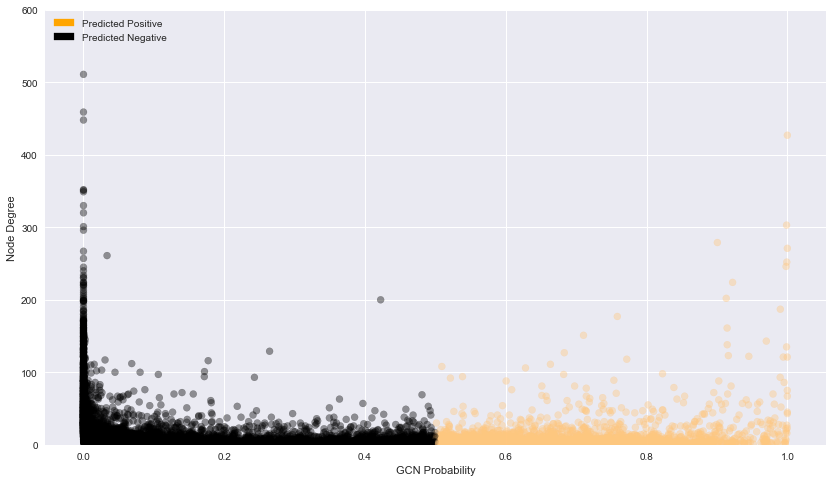

In [319]:
pagerank_scores = pd.DataFrame.from_csv('../data/cancer/pagerank_scores_hotnet_iref.txt', sep='\t')
df = pagerank_scores.join(pred_with_feat, how='inner')
ranks = df.rank(axis=0)

fig = plt.figure(figsize=(14, 8))
plt.scatter(df.Prob_pos, df.neighbors, c=df.Prob_pos >= CLASSIFICATION_THRESHOLD, cmap=plt.cm.copper, alpha=0.4)
plt.gca().set_ylim([0, 600])
plt.xlabel('GCN Probability')
plt.ylabel('Node Degree')
pred = mpatches.Patch(color='orange', label='Predicted Positive')
non_pred = mpatches.Patch(color='black', label='Predicted Negative')
plt.legend(handles=[pred, non_pred], loc='upper left')
fig.savefig(os.path.join(model_dir, 'degree_correlation.png'))

In [320]:
labels_with_pred = labels_df.join(predictions)
predictions_for_pos = labels_with_pred[labels_with_pred.positive == 1]
true_positives = predictions_for_pos[predictions_for_pos.Prob_pos > CLASSIFICATION_THRESHOLD]
no_tp = true_positives.shape[0]
no_positives = predictions_for_pos.shape[0]
pred_pos_test = true_positives[true_positives.test_pos == 1]
pred_pos_train = true_positives[true_positives.train_pos == 1]
predictions_for_neg = labels_with_pred[labels_with_pred.negative == 1]
true_negatives = predictions_for_neg[predictions_for_neg.Prob_pos <= CLASSIFICATION_THRESHOLD]
no_tn = true_negatives.shape[0]
no_fn = predictions_for_neg[predictions_for_neg.Prob_pos > CLASSIFICATION_THRESHOLD].shape[0]
print ("Predicted {} out of {} known infection genes".format(no_tp, no_positives)
      )
print ("Out of these {}, {} were not shown during training.".format(no_positives,
                                                                    y_test[:, 0].sum())
      )
print ("Predicted {} out of {} test genes ({}%)".format(pred_pos_test.shape[0],
                                                        y_test[:,0].sum(),
                                                        pred_pos_test.shape[0]/y_test[:,0].sum()*100.)
      )
print ("Predicted {} out of {} train genes ({}%)".format(pred_pos_train.shape[0],
                                                         y_train[:,0].sum(),
                                                         pred_pos_train.shape[0]/y_train[:,0].sum()*100.)
      )
print ("Correctly rejected {} out of {} true negatives ({}%)".format(no_tn,
                                                                     predictions_for_neg.shape[0],
                                                                     no_tn/predictions_for_neg.shape[0]*100.))
print ("Falsely rejected {} negatives (FN)".format(no_fn))
predictions_for_pos.sort_values(by='Prob_pos', ascending=False).head(20)

Predicted 73 out of 123 known infection genes
Out of these 123, 49 were not shown during training.
Predicted 27 out of 49 test genes (55.10204081632652%)
Predicted 46 out of 74 train genes (62.16216216216216%)
Correctly rejected 1024 out of 1354 true negatives (75.62776957163959%)
Falsely rejected 330 negatives (FN)


,positive,train_pos,test_pos,label,negative,Name,Prob_pos
PIK3CA,1,1,0,1,0,PIK3CA,1.000
TP53,1,1,0,1,0,TP53,1.000
PTEN,1,0,1,0,0,PTEN,1.000
KRAS,1,1,0,1,0,KRAS,1.000
CDKN2A,1,1,0,1,0,CDKN2A,1.000
APC,1,1,0,1,0,APC,1.000
MLL3,1,1,0,1,0,MLL3,0.999
ARID1A,1,1,0,1,0,ARID1A,0.999
PIK3R1,1,1,0,1,0,PIK3R1,0.999
EGFR,1,0,1,0,0,EGFR,0.999


ACCURACY: 0.7754142963146179


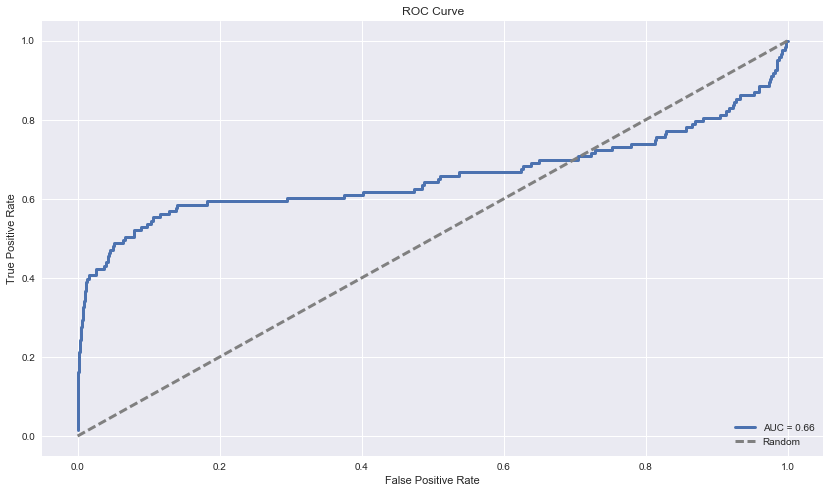

In [321]:
y = np.logical_or(y_train, y_test)
fpr, tpr, thresholds = roc_curve(y[:, 0], predictions.Prob_pos)
roc_auc = roc_auc_score(y[:, 0], predictions.Prob_pos)
fig = plt.figure(figsize=(14, 8))
plt.plot(fpr, tpr, lw=3, label='AUC = {0:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=3, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
fig.savefig(model_dir + 'roc_curve.png')
acc = accuracy_score(y_true=y, y_pred=predictions.Prob_pos >= CLASSIFICATION_THRESHOLD)
print ("ACCURACY: {}".format(acc))

Precision: 0.026574444848926102	Recall: 0.5934959349593496


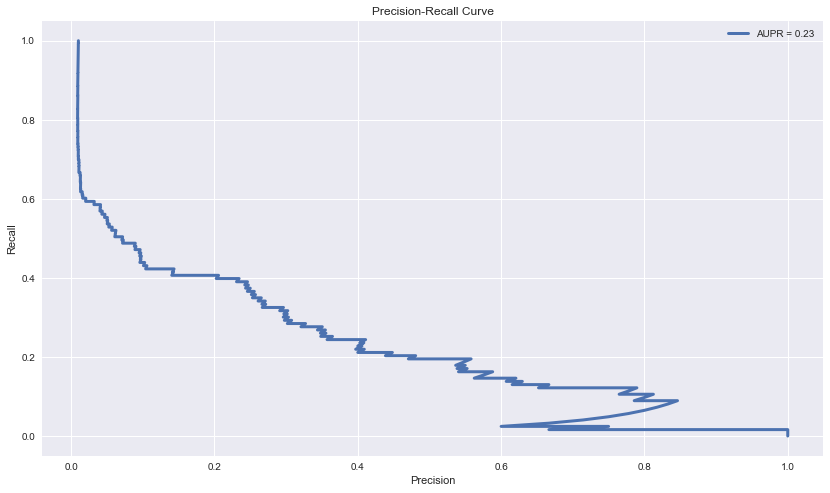

In [322]:
pr, rec, thresholds = precision_recall_curve(y[:, 0], predictions.Prob_pos)
aupr = average_precision_score(y[:,0], predictions.Prob_pos)
fig = plt.figure(figsize=(14, 8))
plt.plot(pr, rec, lw=3, label='AUPR = {0:.2f}'.format(aupr))
#plt.plot([0, 1], [0, 1], color='gray', lw=3, linestyle='--')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
plt.legend()
fig.savefig(model_dir + 'prec_recall.png')
recall = recall_score(y_true=y, y_pred=predictions.Prob_pos >= CLASSIFICATION_THRESHOLD)
precision = precision_score(y_true=y, y_pred=predictions.Prob_pos >= CLASSIFICATION_THRESHOLD)
print ("Precision: {}\tRecall: {}".format(precision, recall))

## Investigate New Model GCN Parameters

In [324]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
checkpoint_path = os.path.join(model_dir, "model.ckpt")
print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='', all_tensors=True)


tensor_name:  mygcn/gclayer_1_vars/weights_0:0
[[-0.69122535  0.23830521  0.20989831  0.2531748  -0.6522523   0.34271187
  -0.7204858  -0.71794075  0.26444498  0.30814177  0.34148288  0.42324674
   0.2489489  -0.67126495  0.35499716  0.20874406  0.4996604  -0.5444501
   0.4393198   0.3545061  -0.6665005  -0.58294517 -0.725502    0.4190925
   0.17417891 -0.69343364 -0.6378127   0.35238928  0.34078673  0.5279305
   0.3803306  -0.708315    0.47893518  0.74085414  0.25725016 -0.713286
  -0.7417754  -0.71257937  0.31810257  0.529836   -0.7007856  -0.6002555
  -0.6482423   0.38554972 -0.60144377  0.33200717  0.27800867 -0.7396637
   0.48825207 -0.6937066 ]]
tensor_name:  mygcn/gclayer_1_vars/weights_1:0
[[-0.6688316  -0.31836727 -0.20591111 -0.3443261  -0.66719896 -0.37008658
  -0.7809224  -0.67680484 -0.24513148 -0.31661645 -0.40720454 -0.43733078
  -0.2392243  -0.58540416 -0.44878483 -0.207757   -0.72122496 -0.6211151
  -0.7137859  -0.5578594  -0.7437756  -0.6251826  -0.74298507 -0.3686927

In [325]:
def str_to_num(s):
    try:
        return int(s)
    except ValueError:
        return float(s)

def load_hyper_params(model_dir):
    file_name = os.path.join(model_dir, 'hyper_params.txt')
    with open(file_name, 'r') as f:
        args = {}
        for line in f.readlines():
            key, value = line.split('\t')
            args[key.strip()] = str_to_num(value.strip())
    print ("Hyper-Parameters read from {}".format(file_name))
    return args

args = load_hyper_params(model_dir)
args

Hyper-Parameters read from ../data/GCN/training/2018_02_13_12_30_40/hyper_params.txt


{'decay': 0.0005,
 'dropout': 0.1,
 'epochs': 3000,
 'hidden1': 50,
 'hidden2': 50,
 'loss_mul': 175.0,
 'lr': 0.01,
 'support': 2}

In [326]:
tf.reset_default_graph()
adj = csr_matrix(network)
F = lil_matrix(features)
F = preprocess_features(F)

poly_support = args['support']
if poly_support > 1:
    support = chebyshev_polynomials(adj, poly_support)
    num_supports = 1 + poly_support
else:
    support = [preprocess_adj(adj)]
    num_supports = 1
print (len(support))
print ([s[2] for s in support])

placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32,
                                      shape=tf.constant(features.shape, dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

def predict(features, support, labels, mask, placeholders):
    feed_dict_pred = construct_feed_dict(features, support, labels, mask, placeholders)
    pred = sess.run(model.predict(), feed_dict=feed_dict_pred)
    return pred

ckpt = tf.train.get_checkpoint_state(checkpoint_dir=model_dir)
ckpt.model_checkpoint_path

if ckpt and ckpt.model_checkpoint_path:
    with tf.Session() as sess:
        model = MYGCN(placeholders,
                      input_dim=features.shape[1],
                      learning_rate=args['lr'],
                      num_hidden1=args['hidden1'],
                      num_hidden2=args['hidden2'],
                      pos_loss_multiplier=args['loss_mul'],
                      weight_decay=args['decay'],
                      logging=True)
        model.load(checkpoint_path, sess)
        print ("loaded")
        weight_matrices = []
        for var in model.vars: # chebychev coefficients
            weight_matrices.append(model.vars[var].eval(session=sess))

        # predict for test set and catch activations in H_1, H_2
        feed_dict = construct_feed_dict(features=F,
                                        support=support,
                                        labels=y_train,
                                        labels_mask=train_mask,
                                        placeholders=placeholders
                                       )
        #l = sess.run(model.loss, feed_dict=feed_dict)
        activations = []
        for layer_act in model.activations:
            activation = sess.run(layer_act, feed_dict=feed_dict)
            activations.append(activation)

len(activations), len(weight_matrices)

/home/sasse/.local/lib/python3.6/site-packages/gcn-1.0-py3.6.egg/gcn/utils.py:97: RuntimeWarning: divide by zero encountered in power


Calculating Chebyshev polynomials up to order 2...
3
[(12129, 12129), (12129, 12129), (12129, 12129)]
{'mygcn/gclayer_1_vars/weights_0:0': <tf.Variable 'mygcn/gclayer_1_vars/weights_0:0' shape=(1, 50) dtype=float32_ref>, 'mygcn/gclayer_1_vars/weights_1:0': <tf.Variable 'mygcn/gclayer_1_vars/weights_1:0' shape=(1, 50) dtype=float32_ref>, 'mygcn/gclayer_1_vars/weights_2:0': <tf.Variable 'mygcn/gclayer_1_vars/weights_2:0' shape=(1, 50) dtype=float32_ref>, 'mygcn/gclayer_3_vars/weights_0:0': <tf.Variable 'mygcn/gclayer_3_vars/weights_0:0' shape=(50, 1) dtype=float32_ref>, 'mygcn/gclayer_3_vars/weights_1:0': <tf.Variable 'mygcn/gclayer_3_vars/weights_1:0' shape=(50, 1) dtype=float32_ref>, 'mygcn/gclayer_3_vars/weights_2:0': <tf.Variable 'mygcn/gclayer_3_vars/weights_2:0' shape=(50, 1) dtype=float32_ref>}
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_02_13_12_30_40/model.ckpt
Model restored from file: ../data/GCN/training/2018_02_13_12_30_40/model.ckpt
loaded


(3, 6)

In [327]:
preds_and_labels = labels_df.join(predictions)
pos_classified = preds_and_labels.Prob_pos >= CLASSIFICATION_THRESHOLD

# set the colors according to classes
preds_and_labels['color'] = 'gray'
preds_and_labels.loc[pos_classified, 'color'] = 'red'
preds_and_labels.loc[~preds_and_labels.label & pos_classified, 'color'] = 'green'
preds_and_labels.groupby('color').count()

,positive,train_pos,test_pos,label,negative,Name,Prob_pos
color,,,,,,,
gray,9382,9382,9382,9382,9382,9382,9382
green,2371,2371,2371,2371,2371,2371,2371
red,376,376,376,376,376,376,376


Plotted TSNE for activation in layer 1 successfully
Plotted TSNE for activation in layer 2 successfully
Plotted TSNE for activation in layer 3 successfully


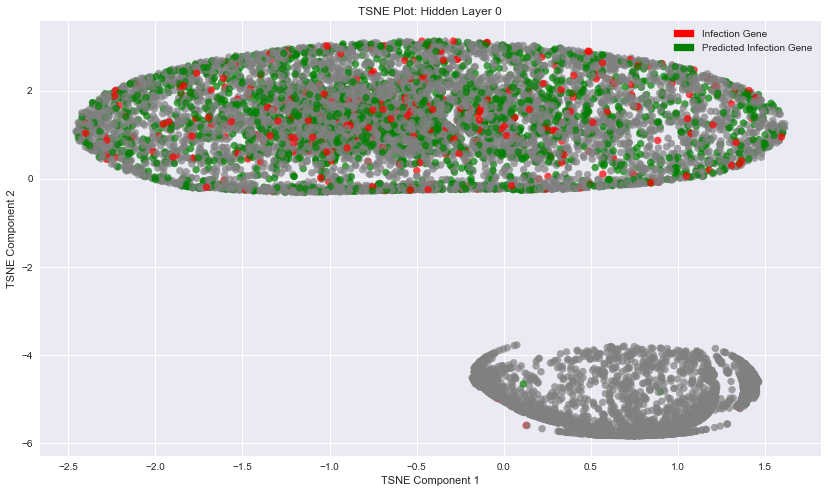

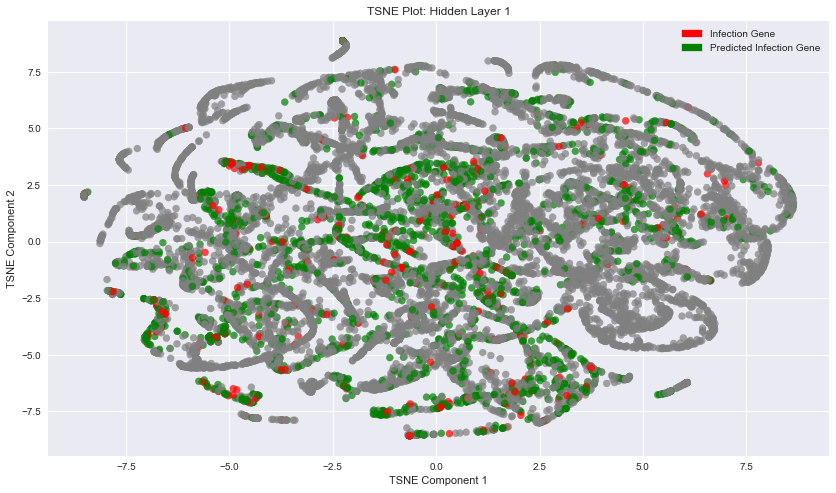

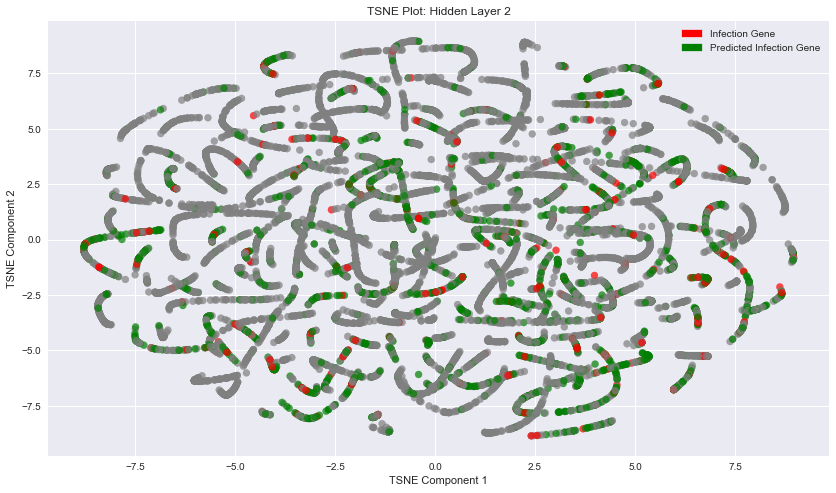

In [328]:
layer_num = 0
embeddings = []
for act in activations:
    if layer_num == 0:
        input_data = coo_matrix((act.values,
                                (act.indices[:, 0], act.indices[:, 1])),
                                shape=act.dense_shape)
        embedding = TSNE(n_components=2).fit_transform(input_data.todense())
    else:
        embedding = TSNE(n_components=2).fit_transform(act)
    embeddings.append(embedding)
    fig = plt.figure(figsize=(14, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=preds_and_labels.color, alpha=0.7)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('TSNE Plot: Hidden Layer {}'.format(layer_num))

    # legend
    inf_genes = mpatches.Patch(color='red', label='Infection Gene')
    pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
    not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
    plt.legend(handles=[inf_genes, pred_genes])

    # save
    fig.savefig(model_dir + '/tsne_{}.png'.format(layer_num), dpi=300)
    layer_num += 1
    print ("Plotted TSNE for activation in layer {} successfully".format(layer_num))

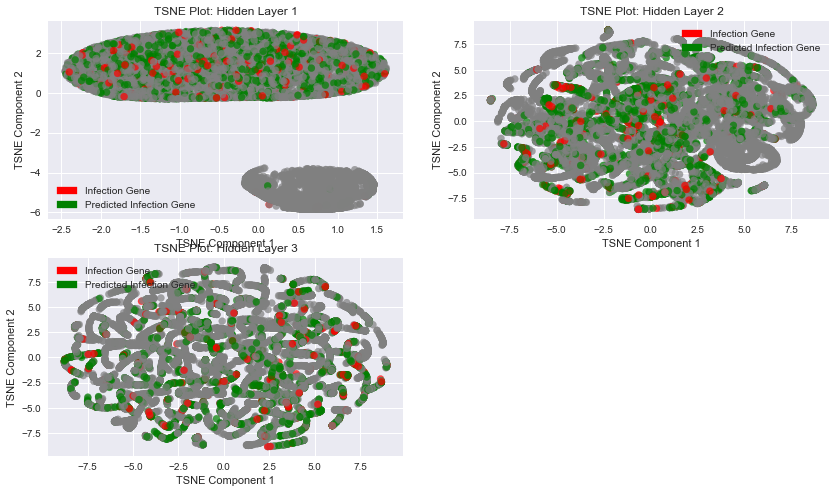

In [329]:
# one plot for all the TSNEs
fig = plt.figure(figsize=(14, 8))
x, y = bestSplit(len(embeddings))
count = 1
for embedding in embeddings:
    plt.subplot(x, y, count)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=preds_and_labels.color, alpha=0.7)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('TSNE Plot: Hidden Layer {}'.format(count))

    # legend
    inf_genes = mpatches.Patch(color='red', label='Infection Gene')
    pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
    not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
    plt.legend(handles=[inf_genes, pred_genes])
    count += 1
fig.savefig('TSNE_all_layers.png', dpi=200)

## Do the predictions have special properties?
I want to check the shortest path between predicted disease genes and true disease genes as well.
Further, I want to see them in a network.

In [330]:
# build networkx graph with correct node names
G = nx.from_numpy_matrix(network)
#mapping = {i:node_names[i, 0] for i in range(node_names.shape[0])}
#nx.relabel_nodes(G, mapping, copy=False)

### Shortest Paths

In [ ]:
# calculate shortest paths between all nodes and make it a dataframe matrix
all_shortest_paths = nx.shortest_path_length(G)
sp_df = pd.DataFrame(dict(all_shortest_paths))

In [ ]:
# build views for label to label shortest paths and non-label to non-label
label_cond = sp_df.index.isin(predictions_for_knowns.index)
label_to_label = sp_df.loc[label_cond, label_cond]
nonlabel_to_nonlabel = sp_df.loc[~label_cond, ~label_cond]
label_to_nonlabel = sp_df.loc[~label_cond, label_cond]

In [ ]:
# plot the distributions
fig = plt.figure(figsize=(14, 8))
bins = np.arange(0, 8, 1)

ltl = pd.Series(label_to_label.values.flatten()).dropna()
ntn = pd.Series(nonlabel_to_nonlabel.values.flatten()).dropna()
ltn = pd.Series(label_to_nonlabel.values.flatten()).dropna()
print (ltl.shape, ntn.shape, ltn.shape)
plt.hist(ltl, bins=bins, alpha=.5, normed=True, color='red',
         label='Infection To Infection (mean {0:.2f})'.format(ltl.mean()))
plt.hist(ntn, bins=bins, alpha=.7, normed=True, color='gray',
         label='Non-Infection To Non-Infection (mean {0:.2f})'.format(ntn.mean()))
plt.hist(ltn, bins=bins, alpha=.3, normed=True, color='blue',
         label='Infection To Non-Infection (mean {0:.2f})'.format(ltn.mean()))
points = np.linspace(0, 8, 100)
plt.plot(points, mlab.normpdf(points, ltl.mean(), ltl.std()), color='red', alpha=0.5)
plt.plot(points, mlab.normpdf(points, ntn.mean(), ntn.std()), color='gray', alpha=0.5)
plt.plot(points, mlab.normpdf(points, ltn.mean(), ltn.std()), color='blue', alpha=0.5)
plt.legend()
plt.title('Histograms of Shortest Paths between Infection Genes and Non-Infection Genes')
plt.xlabel('Shortest Path Length')
plt.ylabel('Normalized Frequency')
fig.savefig(model_dir + '/path_length_distribution.png')

### Node Degree

In [ ]:
# calculate shortest paths between all nodes and make it a dataframe matrix
all_node_degrees = G.degree()
degree_df = pd.Series(dict(all_node_degrees))

# build views for label and non-label degrees
label_cond = degree_df.index.isin(predictions_for_knowns.index)
labels = degree_df[label_cond]
nonlabels = degree_df[~label_cond]
print (labels.shape, nonlabels.shape)

# plot histograms
fig = plt.figure(figsize=(14, 8))
bins = np.arange(0, 50, 1)
plt.hist(labels, bins=bins, alpha=.5, normed=True, color='red',
         label='Infection Genes (Median {})'.format(labels.median()))
plt.hist(nonlabels, bins=bins, alpha=.7, normed=True, color='gray',
         label='Other Genes (Median {})'.format(nonlabels.median()))
plt.legend()
plt.title('Histograms of Node Degree for Infection and Other Genes')
plt.xlabel('Node Degree')
plt.ylabel('Normalized Frequency')
fig.savefig(model_dir + 'node_degrees.png')

### Probability that Neighbor of Infection Gene is also Infection Gene

In [ ]:
# half because of symmetric matrix
num_of_neighbor_labels = label_to_label[label_to_label == 1].count().sum() / 2
prob_neighbor_label = (num_of_neighbor_labels / label_to_label.shape[0]) * 100
print ("Chance of label to have labeled neighbor: {0:.2f} %".format(prob_neighbor_label))

In [ ]:
num_label_nbs = []
num_nbs = []
for label in predictions.index:
    nbs = list(nx.all_neighbors(G, label))
    label_nbs = predictions_for_knowns.index.isin(nbs).sum()
    num_label_nbs.append(label_nbs)
    num_nbs.append(len(nbs))
num_label_nbs = np.array(num_label_nbs)
num_total_nbs = np.array(num_nbs)
print ("Number of labeled neighbors: {}".format(num_label_nbs.sum()))
print ("Number of neighbors total: {}".format(num_total_nbs.sum()))
freq = num_label_nbs.sum()/num_total_nbs.sum()
print ("Chance that neighbor is labeled: {0:.4f}".format(freq))

(array([3533.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8596.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

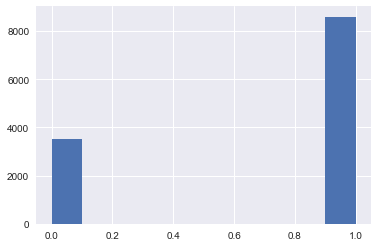

In [296]:
plt.hist(np_input)

In [297]:
rowsum = features.sum(1)
r_inv = np.power(rowsum, -1).flatten()
r_inv[np.isinf(r_inv)] = 0.
r_mat_inv = np.diag(r_inv)
f2 = r_mat_inv.dot(features)

/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


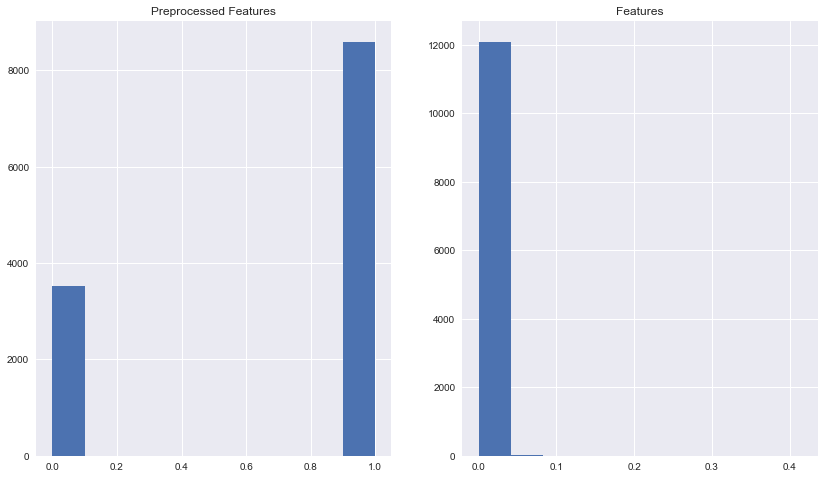

In [298]:
fig = plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
x = plt.hist(f2)
plt.title('Preprocessed Features')
plt.subplot(1, 2, 2)
x = plt.hist(features)
plt.title('Features')

## Correlation with other methods
I will now try to see how similar my performance is to NetRank and PageRank.

In [ ]:
netrank_scores = pd.DataFrame.from_csv('../data/pagerank/netrank_scores.txt', header=0, sep='\t')
netrank_scores.rename(columns={'Rank': 'NetRank_Rank'})
predictions.sort_values('Prob_pos', ascending=False, inplace=True)
predictions['GCN_Rank'] = np.arange(1, predictions.shape[0]+1)
print ("Correlation Rank & Prob: {}".format(predictions.Prob_pos.corr(predictions.GCN_Rank)))

In [ ]:
netrank_with_predictions = predictions.join(netrank_scores, how='inner')
fig = plt.figure(figsize=(14, 14))
plt.scatter(netrank_with_predictions.GCN_Rank, netrank_with_predictions.Rank, color='gray')
lin = np.arange(1, netrank_with_predictions.shape[0]+1)
plt.plot(lin, lin, '--', color='black')

print ("Correlation between NetRank and GCN: {}".format(netrank_with_predictions.Rank.corr(netrank_with_predictions.GCN_Rank)))

In [ ]:
netrank_scores.head()